In [9]:
import os
import torch
from torchvision import transforms
from transformers import BertTokenizer
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import yaml

from data.data import VQADataset

from captum.attr import IntegratedGradients
from captum.attr import visualization as viz

from model.vision_encoder import CNN, ResNet50, SwinTransformer
from model.text_encoder import Bert, RoBerta, BertQLoRA, RoBertaQLoRA
from model.model import VQAModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")

Using device: cuda


In [ ]:
config_path = './cfg/SwinT_RoBertaQLoRA_coco/coattention.yaml'  
model_weights_path = './checkpoints/SwinT_RoBertaQLoRA_coco/coattention/best_model.pth'

output_path = './examples/attention_heatmap.png'  

In [11]:
def load_config(config_path):
    """YAML 설정 파일 로드"""
    with open(config_path, 'r', encoding='utf-8') as f:
        config = yaml.safe_load(f)
    return config

In [12]:
def visualize_attribution_captum(image_path, transform, question, model, tokenizer, device, output_path=None, answer_text=None):
    """
    Captum (Integrated Gradients)을 사용하여 VQA 모델의 기여도를 시각화합니다.
    (모든 오류 수정 버전)
    """
    model.eval()
    
    image = Image.open(image_path).convert('RGB')
    
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    vis_image = image.resize((224, 224))
    vis_image_np = np.array(vis_image)
    
    inputs = tokenizer(question, return_tensors='pt', padding=True, truncation=True)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(images=image_tensor, input_ids=input_ids, attention_mask=attention_mask)
        pred_class = torch.argmax(outputs, dim=1).item()
        confidence = torch.softmax(outputs, dim=1)[0, pred_class].item()

    def model_forward_wrapper(image_input, text_ids, text_mask):
        return model(images=image_input, input_ids=text_ids, attention_mask=text_mask)

    ig = IntegratedGradients(model_forward_wrapper)
    
    captum_inputs = image_tensor
    additional_forward_args = (input_ids, attention_mask)
    
    attributions_ig = ig.attribute(captum_inputs,
                                   target=pred_class,
                                   additional_forward_args=additional_forward_args,
                                   internal_batch_size=1,
                                   n_steps=50)

    attributions_np = attributions_ig.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()

    info_text = f"Question: {question}\n"
    info_text += f"Confidence: {confidence:.4f}"
    if answer_text:
        info_text += f"\nGround Truth: {answer_text}"

    fig1, ax1 = plt.subplots(1, 1, figsize=(5, 5))
    ax1.imshow(vis_image_np)
    ax1.set_title('Original Image', fontsize=14, fontweight='bold')
    ax1.axis('off')

    fig1.text(0.5, 0.02, info_text, ha='center', fontsize=11,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)

    if output_path:
        base, ext = os.path.splitext(output_path)
        original_output_path = f"{base}_original{ext}"
        plt.savefig(original_output_path, dpi=150, bbox_inches='tight')
        print(f"Original image saved to {original_output_path}")
    
    plt.show()

    fig2, ax2 = plt.subplots(1, 1, figsize=(5, 5))
    
    viz.visualize_image_attr(
        attributions_np,
        vis_image_np,
        method="heat_map",        
        sign="absolute_value",    
        show_colorbar=True,
        title="Attribution Map (Integrated Gradients)",
        plt_fig_axis=(fig2, ax2),
        use_pyplot=False              
    )
    
    plt.tight_layout()

    if output_path:
        base, ext = os.path.splitext(output_path)
        attr_output_path = f"{base}_attribution{ext}"
        plt.savefig(attr_output_path, dpi=150, bbox_inches='tight')
        print(f"Attribution heatmap saved to {attr_output_path}")
    
    plt.show()
    
    return pred_class, confidence

In [13]:
VISION_MODELS = {
    "CNN": CNN,
    "ResNet50": ResNet50,
    "SwinTransformer": SwinTransformer
}
TEXT_MODELS = {
    "Bert": Bert,
    "RoBerta": RoBerta,
    "BertQLoRA": BertQLoRA, 
    "RoBertaQLoRA": RoBertaQLoRA
}

config = load_config(config_path)
print("Config loaded:")
print(config)

vision_class = VISION_MODELS.get(config.get('Vision'))
text_class = TEXT_MODELS.get(config.get('Text'))

model = VQAModel(
    vision=vision_class,
    text=text_class,
    fusion_type=config.get('fusion_type'),
    num_classes=config.get('num_classes', 13)
).to(device)

model.load_state_dict(torch.load(model_weights_path, map_location=device))
print(f"Model loaded from {model_weights_path}")

transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print("Tokenizer loaded")

dataset = VQADataset(root_dir="D:/VQA/cocoqa", 
                            split='test',
                            transform=transform)

Config loaded:
{'dataset_root': 'D:/VQA/cocoqa', 'num_classes': 430, 'model_save_path': './checkpoints/SwinT_RoBertaQLoRA_coco/coattention', 'val_split_ratio': 0.1, 'batch_size': 32, 'epochs': 50, 'lr': 1e-05, 'weight_decay': 0.0001, 'num_workers': 4, 'fusion_type': 'co_attention', 'Vision': 'SwinTransformer', 'Text': 'RoBertaQLoRA'}


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from ./checkpoints/SwinT_RoBertaQLoRA_coco/coattention/best_model.pth
Tokenizer loaded
Data sample: 38948, Label: 430.
Tokenizer loaded
Data sample: 38948, Label: 430.


In [14]:
dataset_index =  190 

In [15]:
print(f"Total samples in dataset: {len(dataset)}")
print(f"Valid index range: 0 ~ {len(dataset)-1}")

# 데이터셋에서 샘플 불러오기
if dataset_index < len(dataset):
    try:
        # 데이터셋의 __getitem__ 호출
        sample = dataset[dataset_index]
        
        if sample is not None:
            print(f"\n{'='*50}")
            print(f"Sample Index: {dataset_index}")
            print(f"{'='*50}")
            
            # 데이터셋이 딕셔너리 형태로 반환
            if isinstance(sample, dict):
                question = sample.get('question', '')
                answer_idx = sample.get('answer', None)
                image_tensor = sample.get('image', None)
                
                print(f"Question: {question}")
                
                if answer_idx is not None:
                    answer_text = dataset.idx_to_answer[answer_idx] if answer_idx >= 0 else 'Unknown'
                    print(f"Answer ID: {answer_idx} -> {answer_text}")
                
                # 원본 이미지 로드를 위해 annotations에서 image_id 추출
                annotation = dataset.annotations[dataset_index]
                question_text, answer_text, image_id = annotation
                
                # 이미지 경로 구성
                image_path = None
                for ext in ['.png', '.jpg', '.jpeg']:
                    image_filename = f"{image_id}{ext}"
                    candidate_path = os.path.join(dataset.image_dir, image_filename)
                    if os.path.exists(candidate_path):
                        image_path = candidate_path
                        break
                
                print(f"Image ID: {image_id}")
                print(f"Image path: {image_path}")
                
                if image_path and os.path.exists(image_path):
                    print(f"✓ Image found")
                else:
                    print(f"✗ Error: Image not found")
            else:
                print(f"Unexpected sample type: {type(sample)}")
                image_path = None
                question = None
        else:
            print("Sample is None")
            image_path = None
            question = None
            
    except Exception as e:
        print(f"Error loading sample: {e}")
        import traceback
        traceback.print_exc()
        image_path = None
        question = None
else:
    print(f"\n✗ Error: Index {dataset_index} out of range (0-{len(dataset)-1})")
    image_path = None
    question = None

Total samples in dataset: 38948
Valid index range: 0 ~ 38947

Sample Index: 190
Question: what is laying and looking wide eyed while wearing a scarf
Answer ID: 86 -> cat
Image ID: 282591
Image path: D:/VQA/cocoqa\test\images\282591.jpg
✓ Image found


Original image saved to ./attention_heatmap_original.png


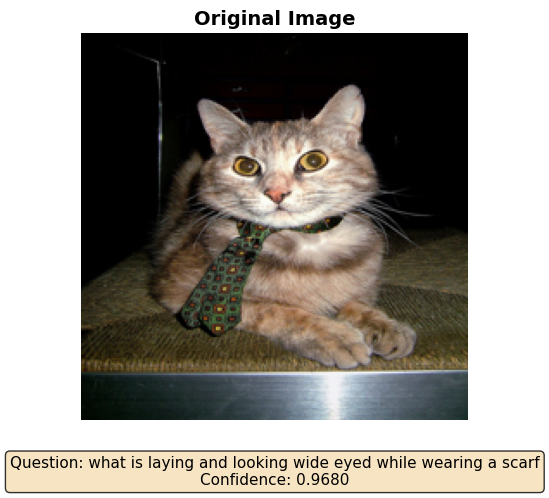

Attribution heatmap saved to ./attention_heatmap_attribution.png


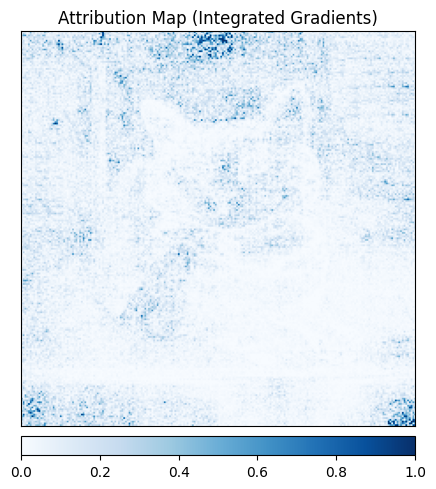


Results:
Predicted class: 86
Confidence: 0.9680


In [16]:
pred_class, confidence = visualize_attribution_captum(
    image_path,
    transform,
    question,
    model,
    tokenizer,
    device,
    output_path=output_path
)

print(f"\nResults:")
print(f"Predicted class: {pred_class}")
print(f"Confidence: {confidence:.4f}")

In [ ]:
# 변수 확인
print(f"image_tensor shape: {image_tensor.shape}")
print(f"image_tensor device: {image_tensor.device}")
print(f"question: {question}")
print(f"model device: {next(model.parameters()).device}")

In [ ]:
def visualize_attribution_with_text(image_path, transform, question, model, tokenizer, device, output_path=None, answer_text=None):
    """
    VQA 모델의 이미지와 텍스트 기여도를 시각화합니다.
    텍스트는 gradient 기반으로 각 토큰의 중요도를 계산합니다.
    """
    model.eval()
    
    # 1. 이미지 로드 및 전처리
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    vis_image = image.resize((224, 224))
    vis_image_np = np.array(vis_image)
    
    # 2. 텍스트 토큰화
    inputs = tokenizer(question, return_tensors='pt', padding=True, truncation=True)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    
    # 토큰 디코딩 (word importance 표시용)
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    
    # 3. 모델 예측
    with torch.no_grad():
        outputs = model(images=image_tensor, input_ids=input_ids, attention_mask=attention_mask)
        pred_class = torch.argmax(outputs, dim=1).item()
        confidence = torch.softmax(outputs, dim=1)[0, pred_class].item()
    
    # =============== 이미지 속성 계산 (Integrated Gradients) ===============
    def model_forward_wrapper_image(image_input):
        return model(images=image_input, input_ids=input_ids, attention_mask=attention_mask)
    
    ig_image = IntegratedGradients(model_forward_wrapper_image)
    attributions_image = ig_image.attribute(
        image_tensor,
        target=pred_class,
        internal_batch_size=1,
        n_steps=50
    )
    attributions_image_np = attributions_image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    
    # =============== 텍스트 속성 계산 (Gradient 기반) ===============
    # BERT의 embedding layer에 접근
    text_encoder = model.text_encoder
    bert_model = text_encoder.bert
    
    # embedding 계산
    with torch.no_grad():
        word_embeddings = bert_model.embeddings.word_embeddings(input_ids)
    
    # embedding을 복사하고 requires_grad 설정
    text_embeddings = word_embeddings.detach().clone()
    text_embeddings.requires_grad = True
    
    # Optimizer 설정 (gradient accumulation용)
    optimizer = torch.optim.SGD([text_embeddings], lr=0.01)
    
    # Forward pass with embedding
    bert_outputs = bert_model(inputs_embeds=text_embeddings, attention_mask=attention_mask)
    q_seq = text_encoder.seq_projection(bert_outputs.last_hidden_state)
    q_global = text_encoder.global_projection(bert_outputs.pooler_output)
    
    # 비전 피처 (고정)
    with torch.no_grad():
        v_seq, v_global = model.vision_encoder(image_tensor)
    
    # Fusion
    fused_feat = model.fusion_module(v_seq, v_global, q_seq, q_global)
    
    # Classification
    logits = model.classifier(fused_feat)
    
    # Target 클래스에 대한 loss
    loss = logits[0, pred_class]
    
    # Backward pass
    loss.backward()
    
    # 각 토큰별 중요도 계산 (gradient magnitude의 합)
    with torch.no_grad():
        token_importance = text_embeddings.grad.abs().sum(dim=-1).squeeze(0).cpu().numpy()
    
    # =============== 시각화 ===============
    info_text = f"Question: {question}\n"
    info_text += f"Predicted Class: {pred_class}\nConfidence: {confidence:.4f}"
    if answer_text:
        info_text += f"\nGround Truth: {answer_text}"
    
    # Figure 1: 원본 이미지
    fig1, ax1 = plt.subplots(1, 1, figsize=(5, 5))
    ax1.imshow(vis_image_np)
    ax1.set_title('Original Image', fontsize=14, fontweight='bold')
    ax1.axis('off')
    fig1.text(0.5, 0.02, info_text, ha='center', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    
    if output_path:
        base, ext = os.path.splitext(output_path)
        original_output_path = f"{base}_original{ext}"
        plt.savefig(original_output_path, dpi=150, bbox_inches='tight')
        print(f"✓ Original image saved to {original_output_path}")
    plt.show()
    
    # Figure 2: 이미지 속성 맵
    fig2, ax2 = plt.subplots(1, 1, figsize=(5, 5))
    viz.visualize_image_attr(
        attributions_image_np,
        vis_image_np,
        method="heat_map",        
        sign="absolute_value",    
        show_colorbar=True,
        title="Image Attribution Map (Integrated Gradients)",
        plt_fig_axis=(fig2, ax2),
        use_pyplot=False              
    )
    plt.tight_layout()
    
    if output_path:
        base, ext = os.path.splitext(output_path)
        attr_output_path = f"{base}_image_attribution{ext}"
        plt.savefig(attr_output_path, dpi=150, bbox_inches='tight')
        print(f"✓ Image attribution heatmap saved to {attr_output_path}")
    plt.show()
    
    # Figure 3: 텍스트 토큰 중요도 바 그래프
    fig3, ax3 = plt.subplots(figsize=(12, 4))
    
    # 토큰 중요도 시각화
    colors = ['#FF6B6B' if imp > np.percentile(token_importance, 75) else '#4472C4' 
              for imp in token_importance]
    bars = ax3.bar(range(len(tokens)), token_importance, color=colors, alpha=0.8)
    
    ax3.set_xlabel('Tokens', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Importance Score', fontsize=12, fontweight='bold')
    ax3.set_title('Word Importance in Question', fontsize=14, fontweight='bold')
    ax3.set_xticks(range(len(tokens)))
    ax3.set_xticklabels(tokens, rotation=45, ha='right')
    ax3.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    if output_path:
        base, ext = os.path.splitext(output_path)
        text_output_path = f"{base}_text_importance{ext}"
        plt.savefig(text_output_path, dpi=150, bbox_inches='tight')
        print(f"✓ Text importance bar chart saved to {text_output_path}")
    plt.show()
    
    # Figure 4: 상세 텍스트 정보 테이블
    fig4, ax4 = plt.subplots(figsize=(12, 4))
    ax4.axis('tight')
    ax4.axis('off')
    
    # 테이블 데이터 생성
    table_data = []
    table_data.append(['Token', 'Importance Score', 'Normalized'])
    
    max_importance = np.max(token_importance) if np.max(token_importance) > 0 else 1
    
    for i, (token, imp) in enumerate(zip(tokens, token_importance)):
        normalized = imp / max_importance
        table_data.append([token, f'{imp:.4f}', f'{normalized:.4f}'])
    
    table = ax4.table(cellText=table_data, cellLoc='center', loc='center',
                     colWidths=[0.3, 0.35, 0.35])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # 헤더 스타일
    for i in range(3):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # 행 색상 지정 (중요도에 따라)
    for i in range(1, len(table_data)):
        normalized = token_importance[i-1] / max_importance
        if normalized > 0.7:
            color = '#FF6B6B'  # 빨강
        elif normalized > 0.4:
            color = '#FFD93D'  # 노랑
        else:
            color = '#C7EFCF'  # 초록
        for j in range(3):
            table[(i, j)].set_facecolor(color)
    
    plt.title('Token-wise Attribution Details', fontsize=14, fontweight='bold', pad=20)
    
    if output_path:
        base, ext = os.path.splitext(output_path)
        detail_output_path = f"{base}_text_details{ext}"
        plt.savefig(detail_output_path, dpi=150, bbox_inches='tight')
        print(f"✓ Text details table saved to {detail_output_path}")
    plt.show()
    
    return pred_class, confidence, tokens, token_importance

In [22]:
# 완전한 visualization with text importance
# 필요한 이미지 텐서 재생성
image = Image.open(image_path).convert('RGB')
image_tensor_viz = transform(image).unsqueeze(0).to(device)
vis_image = image.resize((224, 224))
vis_image_np = np.array(vis_image)

# 초기 예측
with torch.no_grad():
    outputs = model(images=image_tensor_viz, input_ids=input_ids_orig, attention_mask=attention_mask_orig)
    pred_class_viz = torch.argmax(outputs, dim=1).item()
    confidence_orig = torch.softmax(outputs, dim=1)[0, pred_class_viz].item()

tokens = tokenizer.convert_ids_to_tokens(input_ids_orig[0])
token_importance = []

print(f"Question: {question}")
print(f"Tokens: {tokens}")
print(f"Original Confidence: {confidence_orig:.4f}\n")
print(f"Calculating token importance...")

# 각 토큰별 중요도 계산
for token_idx, token in enumerate(tokens):
    input_ids_masked = input_ids_orig.clone()
    input_ids_masked[0, token_idx] = tokenizer.mask_token_id
    
    with torch.no_grad():
        outputs_masked = model(
            images=image_tensor_viz, 
            input_ids=input_ids_masked, 
            attention_mask=attention_mask_orig
        )
        confidence_masked = torch.softmax(outputs_masked, dim=1)[0, pred_class_viz].item()
    
    # 토큰이 마스킹되었을 때 confidence 변화
    importance = confidence_orig - confidence_masked
    token_importance.append(max(0, importance))  # 음수값 제거
    
    print(f"  {token:12} -> Importance: {importance:8.4f}")

token_importance = np.array(token_importance)

print(f"\n{'='*60}")
print(f"Results:")
print(f"{'='*60}")
print(f"Predicted class: {pred_class_viz}")
print(f"Confidence: {confidence_orig:.4f}")
print(f"\nTop 5 Important Tokens:")
top_indices = np.argsort(token_importance)[-5:][::-1]
for idx in top_indices:
    print(f"  {tokens[idx]:15} -> {token_importance[idx]:8.4f}")

Question: what is laying and looking wide eyed while wearing a scarf
Tokens: ['[CLS]', 'what', 'is', 'laying', 'and', 'looking', 'wide', 'eyed', 'while', 'wearing', 'a', 'scarf', '[SEP]']
Original Confidence: 0.9680

Calculating token importance...
  [CLS]        -> Importance:   0.0019
  what         -> Importance:  -0.0002
  is           -> Importance:   0.0123
  laying       -> Importance:   0.0336
  and          -> Importance:  -0.0077
  looking      -> Importance:  -0.0058
  wide         -> Importance:  -0.0007
  eyed         -> Importance:  -0.0026
  while        -> Importance:   0.0000
  wearing      -> Importance:   0.0012
  a            -> Importance:   0.0058
  scarf        -> Importance:   0.0033
  [SEP]        -> Importance:  -0.0012

Results:
Predicted class: 86
Confidence: 0.9680

Top 5 Important Tokens:
  laying          ->   0.0336
  is              ->   0.0123
  a               ->   0.0058
  scarf           ->   0.0033
  [CLS]           ->   0.0019


✓ Bar chart saved to ./text_importance_bar.png


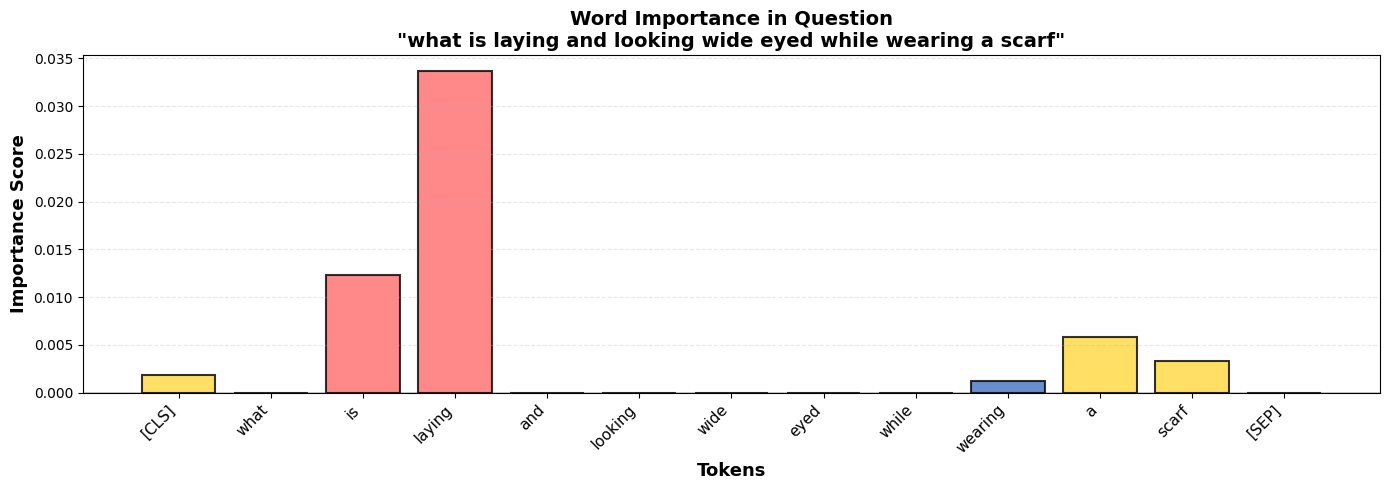

✓ Table saved to ./text_importance_table.png


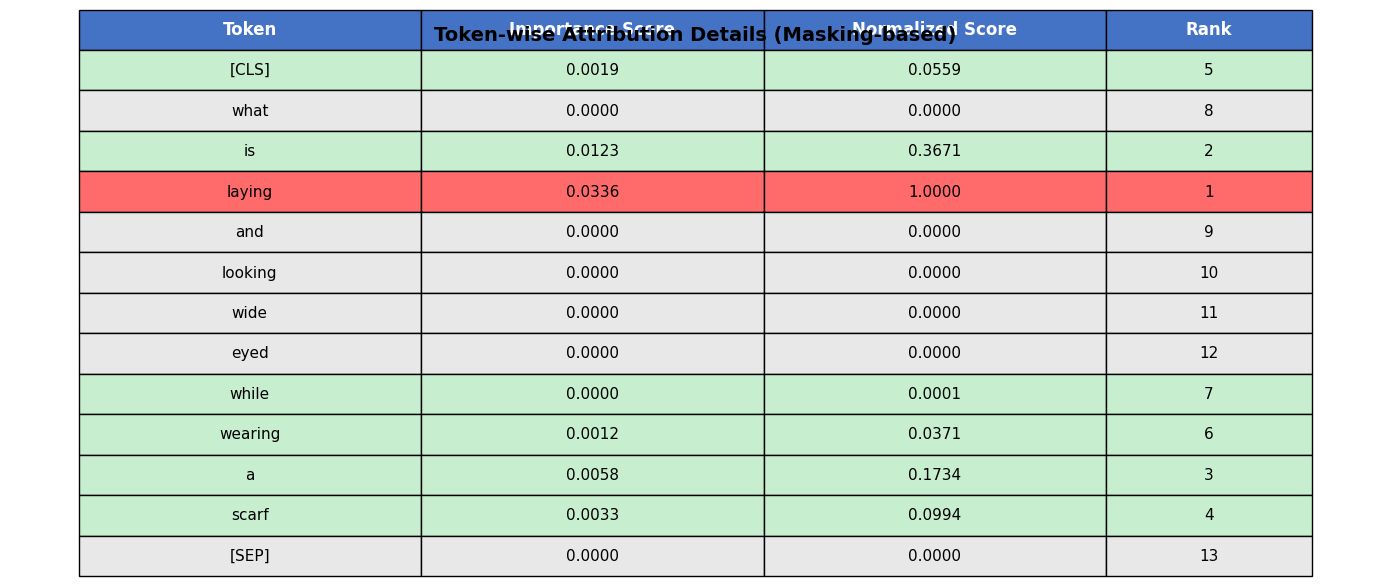


Visualization Complete!


In [23]:
# 시각화 1: 토큰 중요도 바 그래프
fig3, ax3 = plt.subplots(figsize=(14, 5))

# 색상: 중요도가 높을수록 빨강
colors = []
max_imp = np.max(token_importance) if np.max(token_importance) > 0 else 1
for imp in token_importance:
    if imp > np.percentile(token_importance[token_importance > 0], 75) if np.any(token_importance > 0) else 0:
        colors.append('#FF6B6B')  # 빨강 (높음)
    elif imp > np.percentile(token_importance[token_importance > 0], 25) if np.any(token_importance > 0) else 0:
        colors.append('#FFD93D')  # 노랑 (중간)
    else:
        colors.append('#4472C4')  # 파랑 (낮음)

bars = ax3.bar(range(len(tokens)), token_importance, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

ax3.set_xlabel('Tokens', fontsize=13, fontweight='bold')
ax3.set_ylabel('Importance Score', fontsize=13, fontweight='bold')
ax3.set_title(f'Word Importance in Question\n"{question}"', fontsize=14, fontweight='bold')
ax3.set_xticks(range(len(tokens)))
ax3.set_xticklabels(tokens, rotation=45, ha='right', fontsize=11)
ax3.grid(axis='y', alpha=0.3, linestyle='--')
ax3.axhline(y=0, color='black', linewidth=1)

plt.tight_layout()
plt.savefig('./text_importance_bar.png', dpi=150, bbox_inches='tight')
print("✓ Bar chart saved to ./text_importance_bar.png")
plt.show()

# 시각화 2: 상세 테이블
fig4, ax4 = plt.subplots(figsize=(14, 6))
ax4.axis('tight')
ax4.axis('off')

# 테이블 데이터 생성
table_data = []
table_data.append(['Token', 'Importance Score', 'Normalized Score', 'Rank'])

max_importance = np.max(token_importance) if np.max(token_importance) > 0 else 1
ranks = np.argsort(np.argsort(-token_importance)) + 1  # 역순 정렬로 rank 계산

for i, (token, imp, rank) in enumerate(zip(tokens, token_importance, ranks)):
    normalized = imp / max_importance if max_importance > 0 else 0
    table_data.append([token, f'{imp:.4f}', f'{normalized:.4f}', f'{int(rank)}'])

table = ax4.table(cellText=table_data, cellLoc='center', loc='center',
                 colWidths=[0.25, 0.25, 0.25, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# 헤더 스타일
for i in range(4):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white', size=12)

# 행 색상 지정 (중요도에 따라)
for i in range(1, len(table_data)):
    normalized = token_importance[i-1] / max_importance if max_importance > 0 else 0
    if normalized > 0.7:
        color = '#FF6B6B'  # 빨강
    elif normalized > 0.4:
        color = '#FFD93D'  # 노랑
    elif normalized > 0:
        color = '#C7EFCF'  # 초록
    else:
        color = '#E8E8E8'  # 회색
    for j in range(4):
        table[(i, j)].set_facecolor(color)

plt.title('Token-wise Attribution Details (Masking-based)', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('./text_importance_table.png', dpi=150, bbox_inches='tight')
print("✓ Table saved to ./text_importance_table.png")
plt.show()

print(f"\n{'='*60}")
print(f"Visualization Complete!")
print(f"{'='*60}")